# 7-segment displays

This notebook gives a cute example to show off memo's interoperability with the broader JAX ecosystem, which includes deep learning, graphics, physics simulation, and more.

A [seven-segment display](https://en.wikipedia.org/wiki/Seven-segment_display) uses seven lights to display a variety of characters. But when designing a "font" for such a display, [you have to be careful to avoid ambiguities](https://harold.thimbleby.net/cv/files/seven-segment.pdf): for example, a capital "B" and the letter "8" naïvely map to the same pattern (all seven segments on), but are impossible to distinguish. Nonetheless, people have come up with all kinds of [creative variants](https://youtu.be/Th-u84OkpeQ?si=2K01bAX2LjjnXiMJ).

Can we model intuitions about 7-segment displays as a kind of rational communication? To do so, let us start by training a simple neural network model of hand-written character recognition on the EMNIST dataset, using JAX's `flax` ecosystem for deep learning. We will then build a memo model that reasons _over_ this neural network!

We'll start with some imports…

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

import torchvision.datasets

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from memo import memo

Next, we use PyTorch's built-in tools to download and parse the EMNIST dataset.

In [2]:
ds_letter = torchvision.datasets.EMNIST(root='7-aux/data', split='letters', download='True')
ds_number = torchvision.datasets.EMNIST(root='7-aux/data', split='digits', download='True')

In [3]:
feats = []
labls = []

from collections import Counter
cnt = Counter()
for feat, labl in tqdm(ds_number):
    if cnt[labl] > 4800:
        continue
    cnt[labl] += 1
    feats.append(np.array(feat).T)
    labls.append(labl)
for feat, labl in tqdm(ds_letter):
    if 1 <= labl <= 26:
        feats.append(np.array(feat).T)
        labls.append(labl + 10 - 1)

NUM_CLASS = 36

  0%|          | 0/240000 [00:00<?, ?it/s]

  0%|          | 0/124800 [00:00<?, ?it/s]

In [4]:
feats_ = np.expand_dims(np.array(feats), -1)
labls_ = np.expand_dims(np.array(labls), -1)
ds = list(zip(feats_, labls_))

Next, we train a tiny neural network on this dataset. (Or, we load saved weights from a file if a checkpoint exists.)

In [5]:
from flax import linen as nn
from flax.training import train_state
import optax

import orbax.checkpoint
from flax.training import orbax_utils
import os.path


class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x / 255
        # x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        # x = nn.relu(x)
        # x = nn.avg_pool(x, window_shape=(2, 2), strides=(1, 1))
        # x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        # x = nn.relu(x)
        # x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=NUM_CLASS)(x)
        return x


@jax.jit
def apply_model(state, images, labels):
    # print(images.shape, labels.shape)
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, NUM_CLASS)[:, 0, :]
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels[:, 0])
    print((jnp.argmax(logits, -1) == labels[:, 0]).shape)
    return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)


rng = jax.random.key(0)
rng, _ = jax.random.split(rng)
cnn = CNN()
params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
tx = optax.adam(0.0001)
state = train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

if os.path.exists('./7-aux/weights'):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    params = orbax_checkpointer.restore(os.path.abspath('./7-aux/weights'))['state']['params']
    state = train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)
else:
    losses = []
    accs = []
    for epoch in tqdm(range(50)):
        from torch.utils.data import DataLoader
        dl = DataLoader(ds, batch_size=128, shuffle=True)
        for t, (feat, labl) in enumerate((dl)):
            feat = jnp.array(feat)
            labl = jnp.array(labl)
            grads, loss, accuracy = apply_model(state, feat, labl)
            state = update_model(state, grads)
            if t % 400 == 0:
                losses.append(loss)
                accs.append(accuracy)
        # print(epoch, loss, accuracy)

    plt.plot(accs)
    plt.ylabel('Accuracy')
    plt.xlabel('Time')

    ckpt = {'state': state}
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(ckpt)
    orbax_checkpointer.save(os.path.abspath('./7-aux/weights'), ckpt, save_args=save_args)

Now, let's feed our trained neural network some 7-segment displays and see how it does. We can generate 7-segment displays in JAX by performing simple pixel manipulations on an array.

Do the neural network's guesses match your intuitions?

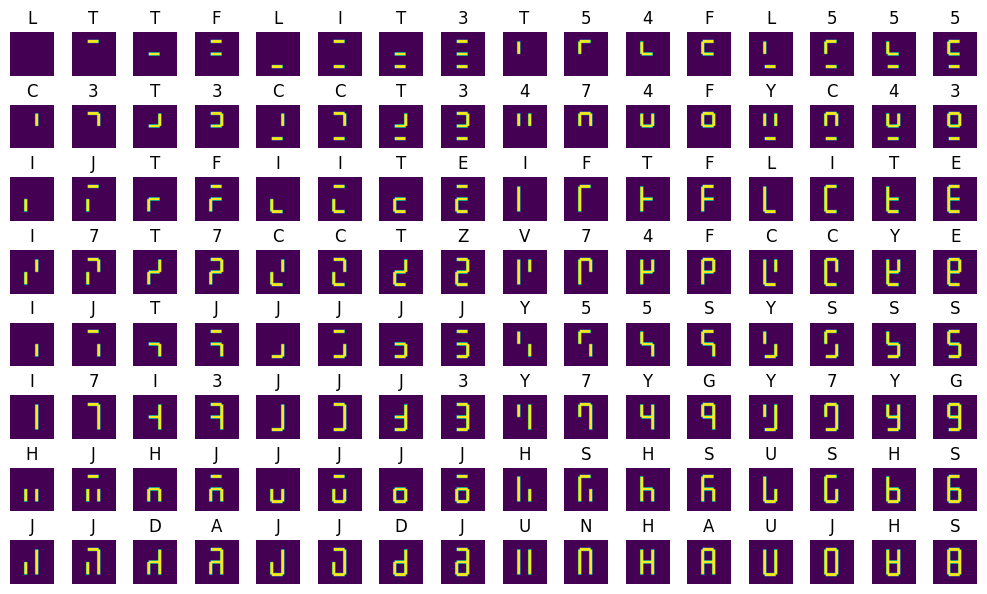

In [6]:
@jax.jit
def predict(img):
    return state.apply_fn(
        {'params': state.params},
        jnp.expand_dims(img, (0, -1))
    )[0]

@jax.jit
def make_7seg(i):
    L = +10
    R = -12
    U = 5
    M = 13
    D = 21
    canvas = jnp.zeros((28, 28))
    segs = [(i & (1 << n)) != 0 for n in range(7)]
    canvas = canvas.at[ U, L:R].set(segs[0])
    canvas = canvas.at[ M, L:R].set(segs[1])
    canvas = canvas.at[ D, L:R].set(segs[2])
    canvas = canvas.at[ U+1:M, L-1].set(segs[3])
    canvas = canvas.at[ U+1:M, R].set(segs[4])
    canvas = canvas.at[ M+1:D, L-1].set(segs[5])
    canvas = canvas.at[ M+1:D, R].set(segs[6])
    canvas = (
        canvas
        + jnp.roll(canvas, 1, axis=0)
        + jnp.roll(canvas, 1, axis=1)
        + jnp.roll(jnp.roll(canvas, 1, axis=0), 1, axis=1)
    )

    canvas = 255 * (canvas != 0)
    return canvas

plt.figure(figsize=(10, 6))
for i in range(128):
    plt.subplot(8, 16, i + 1)
    img = np.array(make_7seg(i))
    plt.imshow(img)
    import string
    chars = string.digits + string.ascii_uppercase
    name = chars[predict(img).argsort()[-1]]
    plt.title(name)
    plt.axis('off')
plt.tight_layout()

Finally, let's build an RSA model where the literal listener is modeled as running our neural network on the input image ("utterance") and taking the logits as the log-posterior. Notice that the utterance space is 128, i.e. $2^7$ configurations of the seven-segment display, and the referent space is 36, i.e. 10 digits + 26 letters.

In [7]:
from memo import memo

NUL = 256

U = jnp.arange(128)
R = jnp.arange(36)
# R = jnp.arange(7)
# R = jnp.array([6, 8, 11, 9, 16, 26, NUL])
# R = jnp.array([9, 16, 26, NUL])
# R = jnp.array([9, 16, NUL])

@jax.jit
def pretrained_classifier(u, r):
    z = jnp.exp(predict(make_7seg(u)))
    z = z / jnp.sum(z)
    return jnp.where(r == NUL, z.sum() - z[r], z[r])

@memo
def speaker[u: U, r: R](beta, t):
    speaker: knows(r)
    speaker: chooses(u in U, wpp=
        exp(beta * listener[u, r](beta, t)) if t > 0 else pretrained_classifier(u, r)
    )
    return E[speaker.u == u]

@memo
def listener[u: U, r: R](beta, t):
    listener: thinks[
        speaker: chooses(r in R, wpp=10 if r == 256 else 1),
        speaker: chooses(u in U, wpp=speaker[u, r](beta, t - 1))
    ]
    listener: observes [speaker.u] is u
    listener: chooses(r in R, wpp=E[speaker.r == r])
    return E[listener.r == r]

Now, we can see how the emergent convention / "font" changes as we add more levels of recursive reasoning.

CPU times: user 200 ms, sys: 19.4 ms, total: 220 ms
Wall time: 170 ms


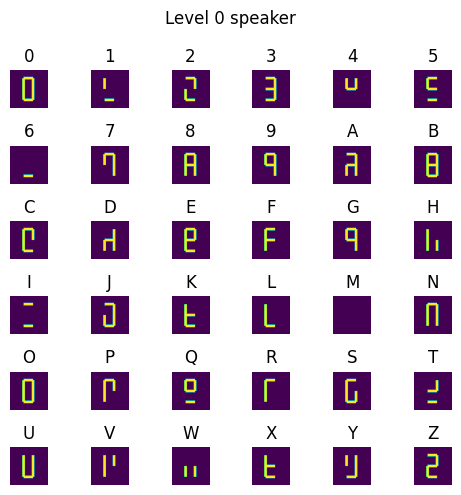

CPU times: user 185 ms, sys: 12.9 ms, total: 198 ms
Wall time: 108 ms


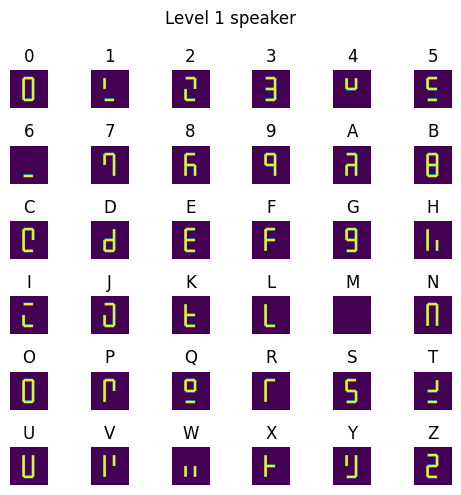

CPU times: user 159 ms, sys: 11.5 ms, total: 170 ms
Wall time: 37 ms


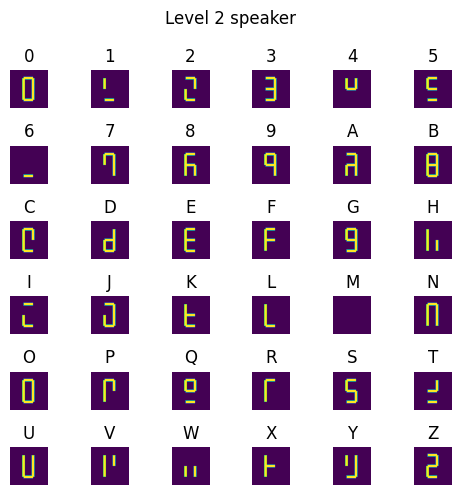

CPU times: user 215 ms, sys: 15.6 ms, total: 230 ms
Wall time: 50 ms


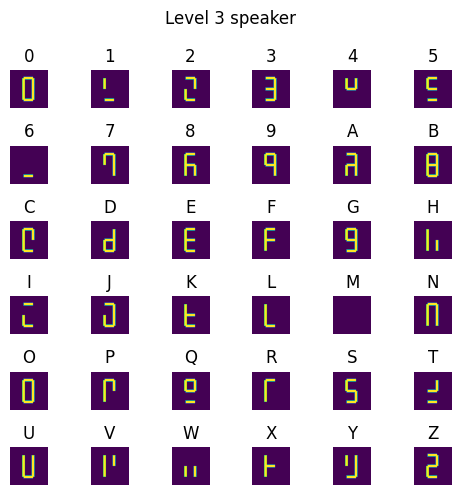

In [8]:
for t in range(4):
    plt.figure(figsize=(5, 5))
    %time S = speaker(1.0, t)
    plt.suptitle(f'Level {t} speaker')
    for i, r in enumerate(list(R)):
        if r == NUL:
            continue
        plt.subplot(6, 6, i + 1)
        plt.imshow(make_7seg(jnp.argmax(S[:, i])))
        plt.axis('off')
        plt.title(chars[R[i]])
    plt.tight_layout()
    plt.show()

This demo isn't perfect, but you can see that the strategic speakers are "trying" to minimize ambiguity, and often come up with some pretty "clever" solutions as well (I particularly like the "V").

By the way, notice the timestamps: memo evaluations are just milliseconds.